# Next Steps (as of October 20, 2018)
So we got the file put into a potentially readable format for a bipartite network in networkx, but we still have a lot of work to do!

**Audrey**
* Figure out what format this file needs to be in in order to load into networkx as a bipartite
* Create a bipartite network!

**Cassie**
* Figure out and get the thresholds for pollutants in California (esp. if they're different than what we have)
* Put those thresholds into a format that can be easily used by the code we've written

# Water Quality Network
For our network project, Cassie and I are thinking of creating a bipartite network where the nodes are pollutants and the links are water facilities whose measurements of those pollutants are above the threshold. By doing this linking, we hope to see what the biggest pollutants are, how pollutants might connect to one another, and if there are any pollutants that we should be worried about.

## Data Sources
We got our data from USGS (U.S. Geological Survey). I'll need to get the exact link later.

## Looking at the data
Since I'm not too familiar with the data, let's load it in and take a look. There's some preliminary things that I do know, which will be come prevelant when you look at the code. For instance, you can break up the code into chunks by splitting on instances of "#\n". The # comes from the file header and most "sections" within the header are separated by # followed by a new line. The last item of the split is the actual data.

Let's start by loading in everything!

## MUST PIP INSTALL
* numpy
* pandas
* matplotlib
* xlrd

In [558]:
import re
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
%matplotlib inline

In [2]:
def load_data(file_name):
    data = []
    with open(file_name, 'r') as file:
        data = file.read().split("#\n")

    if not data:
        print("File {} was unable to be read.".format(file_name))
    return data

In [3]:
file_name = "LA_Water_Quality_Data.txt"
data = load_data(file_name)
print("Number of sections:", len(data))
print("2nd section:", data[2], sep = "\n")
print("Number of characters in actual data:", len(data[15]))

Number of sections: 16
2nd section:
# U.S. Geological Survey
# 
# This file contains selected water-quality data for stations in the National Water Information 
# System water-quality database.  Explanation of codes found in this file are followed by
# the retrieved data.

Number of characters in actual data: 9736982


Great! We have 15 chunks of text when doing that split (which feels a bit better than doing it line-by-line). Here's a breakdown of what's inside:
    #  0:                               #  8: coll_ent_cd  
    #  1: File created...               #  9: medium_cd  
    #  2: U.S. Geological Survey        # 10: tu_id  
    #  3: The data you have...          # 11: body_part_id  
    #  4: To view additional...         # 12: remark_cd  
    #  5: Param_id      - parameter     # 13: Data for the following sites...  
    #  6: sample_start_time_datum_cd    # 14: WARNING: some preadsheet...  
    #  7: tm_datum_rlbty_cd             # 15: Data!  

I've already glanced at the file in Excel and figured out how to parse all of the parameters and their descriptions, which will probably be useful later on. 

In [4]:
# inputs the part of the header that contains the parameter label followed by its meaning
# outputs a dictionary where the key is the label (lower case) and the value is the description
def get_parameter_def(param_header):
    params_dict = {}
    params_type = {}
    params = param_header.split("\n")
    params_pattern = re.compile("# +(\w+) +- +(.+)")

    for param in params:
        a = params_pattern.search(param)

        if a: 
            #print(first_t, a.group(1), a.group(2))
            params_dict[a.group(1).lower()] = a.group(2)
            #print(a.group(1) + ":", a.group(2).split(',')[-1])

    return params_dict

In [5]:
params_dict = get_parameter_def(data[5])
print("Total number of parameters measured:", len(params_dict))

Total number of parameters measured: 1046


In [6]:
needed_params = ["site_no", "sample_dt", "sample_tm"]
data_params = [param for param in params_dict if param[0] == "p"]
#params_dict

In [7]:
data_to_use = pd.read_csv(pd.compat.StringIO(data[15]), sep='\t', low_memory=False, header=0, skiprows=[1])
# I find this a bit concerning...: https://stackoverflow.com/questions/24251219/pandas-read-csv-low-memory-and-dtype-options
# I'd want to specify type, but it seems like there's a lot of strings within supposedly numerical columns...
print(data_to_use.shape)
display(data_to_use.head(2))

(7763, 1046)


,agency_cd,site_no,sample_dt,sample_tm,sample_end_dt,sample_end_tm,sample_start_time_datum_cd,tm_datum_rlbty_cd,coll_ent_cd,medium_cd,...,p99856,p99871,p99931,p99947,p99958,p99959,p99963,p99972,p99994,p99995
0,USGS,332031118504001,2000-10-24,14:30,NaN,NaN,PDT,T,USGS-WRD,WG,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USGS,333420118060501,2000-11-09,09:30,NaN,NaN,PST,T,USGS-WRD,WG,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
data_to_use_numbers = data_to_use[data_params]
data_to_use_numbers.head()

,p00003,p00004,p00005,p00008,p00009,p00010,p00011,p00020,p00021,p00025,...,p99856,p99871,p99931,p99947,p99958,p99959,p99963,p99972,p99994,p99995
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,18.5,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,973.0,90.7,99.8
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
data_to_use_numbers = data_to_use_numbers.replace("[<> A-Za-z]", "", regex=True)
data_to_use_numbers = data_to_use_numbers.replace(" ", "", regex=True)
data_to_use_numbers = data_to_use_numbers.replace(r'^$', np.nan, regex=True)

In [10]:
data_to_use_numbers = data_to_use_numbers.astype(np.float64)

In [11]:
#total_data = pd.concat([data_to_use[needed_params], data_to_use_numbers], axis=1)

In [12]:
#total_data.head()

## Splitting params into filtered and unfiltered
* unfiltered = grab the ground water as is - you have extra sediment somehow
* filtered = you filter out the ground water 
* do analysis with filtered and unfiltered, but DON'T MIX
* higher pollution for unfiltered properties

#### Note
There's some descrepencies in these parameters. We'll deal with this later.

In [137]:
filtered_params_1 = {}
unfiltered_params_1 = {}
for param in params_dict.items():
    components = param[1].split(", ")
    component = components[0].lower()
    if "filtered" in components:
        if component not in filtered_params_1:
            filtered_params_1[component] = []
        filtered_params_1[component].append(param[0])
    elif "unfiltered" in components:
        if component not in unfiltered_params_1:
            unfiltered_params_1[component] = []
        unfiltered_params_1[component].append(param[0])
        
filtered_params_2 = {}
unfiltered_params_2 = {}
for param in params_dict.items():
    components = param[1].split(", ")
    component = components[0].lower()
    if "unfiltered" not in components: #"filtered" in components:
        if component not in filtered_params_2:
            filtered_params_2[component] = []
        filtered_params_2[component].append(param[0])
    elif "filtered" not in components: #"unfiltered" in components:
        if component not in unfiltered_params_2:
            unfiltered_params_2[component] = []
        unfiltered_params_2[component].append(param[0])

In [138]:
print("For first method:")
print(len(set(filtered_params_1).intersection(set(unfiltered_params_1))))
print(len(filtered_params_1))
print(len(unfiltered_params_1))

print("For second method:")
print(len(set(filtered_params_2).intersection(set(unfiltered_params_2))))
print(len(filtered_params_2))
print(len(unfiltered_params_2))

print(len(set(filtered_params_2).difference(filtered_params_1)))
print(len(set(unfiltered_params_2).difference(unfiltered_params_1)))
print(518-197)

For first method:
57
197
360
For second method:
127
518
360
321
0
321


In [139]:
# This is writing the params into a file
#unfiltered_file = open("Unfiltered_params.txt", "w")
#filtered_file = open("Filtered_params.txt", "w")
#
#for param in unfiltered_params.items():
#    formatSTR = param[0] + "\t" + "\t".join(param[1]) + "\r\n"
#    unfiltered_file.write(formatSTR.lower())
#unfiltered_file.close()
#for param in filtered_params.items():
#    formatSTR = param[0] + "\t" + "\t".join(param[1]) + "\r\n"
#    filtered_file.write(formatSTR.lower())
#filtered_file.close()

## Next Step: Getting the pollutants 

In [140]:
pollutant_file = pd.ExcelFile("Thresholds_hh_USGScompatible.xlsx")
convert_to_str = {name:str for name in pd.read_excel("Thresholds_hh_USGScompatible.xlsx").columns.values.tolist()}
pollutant_info = pollutant_file.parse(converters=convert_to_str)

In [141]:
pollutant_info = pollutant_info[pollutant_info["Pollutant (P = priority pollutant)"].notna()]
pollutant_info["Pollutant (P = priority pollutant)"] = pollutant_info["Pollutant (P = priority pollutant)"].str.strip()
pollutant_info["Pollutant (P = priority pollutant)"] = pollutant_info["Pollutant (P = priority pollutant)"].str.lower()
#pollutant_info["Human Health for the consumption of\xa0Water + Organism (µg/L)"] = pollutant_info["Human Health for the consumption of\xa0Water + Organism (µg/L)"].astype(str)
pollutant_info["Human Health for the consumption of\xa0Water + Organism (µg/L)"] = pollutant_info["Human Health for the consumption of\xa0Water + Organism (µg/L)"].str.replace("<", "")
pollutant_info["Human Health for the consumption of\xa0Water + Organism (µg/L)"] = pollutant_info["Human Health for the consumption of\xa0Water + Organism (µg/L)"].str.strip()
has_ranges = pollutant_info["Human Health for the consumption of\xa0Water + Organism (µg/L)"].str.contains("-")
ranges = pollutant_info[has_ranges]
ranges
pollutant_info = pollutant_info[~has_ranges]
pollutant_info["Human Health for the consumption of\xa0Water + Organism (µg/L)"] = pd.to_numeric(pollutant_info["Human Health for the consumption of\xa0Water + Organism (µg/L)"])
pollutant_info.head()

,Pollutant (P = priority pollutant),CAS Number,Human Health for the consumption of Water + Organism (µg/L),Human Health for the consumption of Organism Only (µg/L),Publication Year,Notes
0,acenaphthene,83329,7.000000e+01,90,2015,The criterion for organoleptic (taste and odor...
1,acrylonitrile,107131,6.100000e-02,7,2015,This criterion is based on carcinogenicity of ...
2,aldrin,309002,7.700000e-07,7.7e-07,2015,This criterion is based on carcinogenicity of ...
3,alpha-hch,319846,3.600000e-04,0.00039,2015,This criterion is based on carcinogenicity of ...
4,alpha-endosulfan,959988,2.000000e+01,30,2015,NaN


In [366]:
# Where we got the columns with the same pollutant names
common_pollutants_p = []
reverse_params_dict = {}
pollutant_info["Pollutant (P = priority pollutant)"]=pollutant_info["Pollutant (P = priority pollutant)"].str.lower()
a = pollutant_info["Pollutant (P = priority pollutant)"]
a = a[a.notna()]
for pollutant in a:
    pollutant = pollutant
    if pollutant in filtered_params_2:
        for column in filtered_params_2[pollutant]:
            common_pollutants_p.append(column)
            reverse_params_dict[column] = pollutant
#reverse_params_dict
#common_pollutants_p

In [393]:
reverse_params_dict

{'p39333': 'aldrin',
 'p34253': 'alpha-hch',
 'p34362': 'alpha-endosulfan',
 'p39389': 'alpha-endosulfan',
 'p63180': 'anthracene',
 'p01095': 'antimony',
 'p01000': 'arsenic',
 'p01001': 'arsenic',
 'p01003': 'arsenic',
 'p01005': 'barium',
 'p01006': 'barium',
 'p63183': 'benzo[a]pyrene',
 'p01010': 'beryllium',
 'p63187': 'bis(2-ethylhexyl) phthalate',
 'p01025': 'cadmium',
 'p01026': 'cadmium',
 'p01028': 'cadmium',
 'p01030': 'chromium',
 'p01031': 'chromium',
 'p01040': 'copper',
 'p01041': 'copper',
 'p01043': 'copper',
 'p00721': 'cyanide',
 'p39381': 'dieldrin',
 'p39383': 'dieldrin',
 'p63202': 'diethyl phthalate',
 'p61590': 'endosulfan sulfate',
 'p39393': 'endrin',
 'p63208': 'fluoranthene',
 'p39413': 'heptachlor',
 'p39423': 'heptachlor epoxide',
 'p63212': 'isophorone',
 'p01054': 'manganese',
 'p01056': 'manganese',
 'p39481': "p,p'-methoxychlor",
 'p01065': 'nickel',
 'p01066': 'nickel',
 'p01068': 'nickel',
 'p00618': 'nitrate',
 'p71851': 'nitrate',
 'p63225': 'phen

In [143]:
total_data = pd.concat([data_to_use[needed_params], data_to_use_numbers[common_pollutants_p]], axis=1)
#data_to_use_subset.head()

#total_data.notna().sum() # <- this is useful when looking at how many values each column has

In [144]:
total_data.shape

(7763, 59)

In [367]:
common_pollutants_p

['p39333',
 'p34253',
 'p34362',
 'p39389',
 'p63180',
 'p01095',
 'p01000',
 'p01001',
 'p01003',
 'p01005',
 'p01006',
 'p63183',
 'p01010',
 'p63187',
 'p01025',
 'p01026',
 'p01028',
 'p01030',
 'p01031',
 'p01040',
 'p01041',
 'p01043',
 'p00721',
 'p39381',
 'p39383',
 'p63202',
 'p61590',
 'p39393',
 'p63208',
 'p39413',
 'p39423',
 'p63212',
 'p01054',
 'p01056',
 'p39481',
 'p01065',
 'p01066',
 'p01068',
 'p00618',
 'p71851',
 'p63225',
 'p39519',
 'p63227',
 'p01145',
 'p01146',
 'p01148',
 'p70301',
 'p70302',
 'p70303',
 'p01057',
 'p39403',
 'p01090',
 'p01091',
 'p01093',
 'p63163',
 'p49299']

### Try the CA Pollutants instead 

In [304]:
ca_pollutant_file = pd.ExcelFile("CA_thresholds_compliation_filtered.xlsx")
ca_pollutant_info = ca_pollutant_file.parse()

In [305]:
ca_pollutant_info.head()

,Name1,Name2,Name3,Name4,Sort_Name,CAS_Number,Organic_Inorganic,CA_Prim_MCL,CA_Prim_MCL_2,CA_Prim_MCL_unit,...,CA_BayEst_Health_unit,CA_BayEst_Health_date,NAWQC_Health_WF,NAWQC_Health_WF_2,NAWQC_Health_WF_unit,NAWQC_Health_WF_date,NAWQC_Health_F,NAWQC_Health_F_2,NAWQC_Health_F_unit,NAWQC_Health_F_date
0,Acenaphthene,NaN,NaN,NaN,Acenaphthene,83-32-9,Organic,NaN,NaN,NaN,...,NaN,2000-05-18,70.0,NaN,NaN,2015-06-29,90.0,NaN,NaN,2015-06-29
1,Acenaphthylene,NaN,NaN,NaN,Acenaphthylene,208-96-8,Organic,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT
2,Acetochlor,NaN,NaN,NaN,Acetochlor,34256-82-1,Organic,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT
3,Acetone,NaN,NaN,NaN,acetone,67-64-1,Organic,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT
4,Acetonitrile,NaN,NaN,NaN,Acetonitrile,75-05-8,Organic,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT


In [311]:
ca_pollutant_info.iloc[:, :5] = ca_pollutant_info.iloc[:, :5].replace(to_replace=np.nan, value="")
names = ca_pollutant_info["Name1"].copy(deep = True)
names = names.str.lower()
names.head()
ca_pollutant_info.head()

,Name1,Name2,Name3,Name4,Sort_Name,CAS_Number,Organic_Inorganic,CA_Prim_MCL,CA_Prim_MCL_2,CA_Prim_MCL_unit,...,CA_BayEst_Health_unit,CA_BayEst_Health_date,NAWQC_Health_WF,NAWQC_Health_WF_2,NAWQC_Health_WF_unit,NAWQC_Health_WF_date,NAWQC_Health_F,NAWQC_Health_F_2,NAWQC_Health_F_unit,NAWQC_Health_F_date
0,Acenaphthene,,,,Acenaphthene,83-32-9,Organic,NaN,NaN,NaN,...,NaN,2000-05-18,70.0,NaN,NaN,2015-06-29,90.0,NaN,NaN,2015-06-29
1,Acenaphthylene,,,,Acenaphthylene,208-96-8,Organic,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT
2,Acetochlor,,,,Acetochlor,34256-82-1,Organic,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT
3,Acetone,,,,acetone,67-64-1,Organic,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT
4,Acetonitrile,,,,Acetonitrile,75-05-8,Organic,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT


In [356]:
filtered_params_2

{'agency code': ['agency_cd'],
 'station number': ['site_no'],
 'begin date': ['sample_dt'],
 'begin time': ['sample_tm'],
 'end date': ['sample_end_dt'],
 'end time': ['sample_end_tm'],
 'time datum': ['sample_start_time_datum_cd'],
 'time datum reliability code': ['tm_datum_rlbty_cd'],
 'agency collecting sample code': ['coll_ent_cd'],
 'medium code': ['medium_cd'],
 'taxonomic unit code': ['tu_id'],
 'body part code': ['body_part_id'],
 'sampling depth': ['p00003', 'p00098'],
 'stream width': ['p00004'],
 'location in cross section': ['p00005', 'p00009'],
 'sample accounting number': ['p00008'],
 'temperature': ['p00010', 'p00011', 'p00020', 'p00021'],
 'barometric pressure': ['p00025'],
 'agency analyzing sample': ['p00028'],
 'project number': ['p00029'],
 'cloud cover': ['p00032'],
 'flow rate of well': ['p00058'],
 'flow rate': ['p00059'],
 'discharge': ['p00060', 'p00061', 'p30208', 'p30209'],
 'gage height': ['p00065', 'p30207'],
 'color': ['p00080'],
 'odor at room temperatur

In [409]:
count = 0
all_params = list(filtered_params_2.keys())# + list(unfiltered_params_2.keys())
rows_containing_pollutant = []
names_of_pollutant = []
common_pollutants_p = []
reverse_params_dict = {}
for column in all_params:
    if np.any(names.str.match(column)):
        match_col = np.where(names.str.match(column))[0]
        print(column, match_col, type(match_col))
        rows_containing_pollutant += match_col.tolist()
        for i in range(len(match_col)):
            names_of_pollutant.append(column)
        for p_column in filtered_params_2[column]:
            reverse_params_dict[p_column] = column
            common_pollutants_p.append(p_column)
        count += 1
total_data = pd.concat([data_to_use[needed_params], data_to_use_numbers[common_pollutants_p]], axis=1)
#reverse_params_dict = {column:pollutant for column,pollutant in zip(common_pollutants_p,names_of_pollutant)}

nitrite [187] <class 'numpy.ndarray'>
nitrate [186] <class 'numpy.ndarray'>
phosphorus [208 209] <class 'numpy.ndarray'>
cyanide [91] <class 'numpy.ndarray'>
sodium [229] <class 'numpy.ndarray'>
chloride [66] <class 'numpy.ndarray'>
sulfate [232] <class 'numpy.ndarray'>
fluoride [148] <class 'numpy.ndarray'>
arsenic [19] <class 'numpy.ndarray'>
barium [22] <class 'numpy.ndarray'>
beryllium [33] <class 'numpy.ndarray'>
boron [40] <class 'numpy.ndarray'>
cadmium [58] <class 'numpy.ndarray'>
chromium [81 82] <class 'numpy.ndarray'>
cobalt [84] <class 'numpy.ndarray'>
copper [85] <class 'numpy.ndarray'>
iron [163] <class 'numpy.ndarray'>
lead [166] <class 'numpy.ndarray'>
manganese [169] <class 'numpy.ndarray'>
thallium [239] <class 'numpy.ndarray'>
molybdenum [182] <class 'numpy.ndarray'>
nickel [185] <class 'numpy.ndarray'>
silver [227] <class 'numpy.ndarray'>
strontium [230] <class 'numpy.ndarray'>
vanadium [260] <class 'numpy.ndarray'>
antimony [18] <class 'numpy.ndarray'>
aluminum [14

In [410]:
print(len(common_pollutants_p), len(reverse_params_dict))

188 188


In [370]:
len(common_pollutants_p)

188

In [371]:
#print(sorted(rows_containing_pollutant))
print(count)

142


In [372]:
len(names_of_pollutant)

150

In [373]:
chosen_ca_pollutant_info = ca_pollutant_info.iloc[rows_containing_pollutant, :]
chosen_ca_pollutant_info.shape

(150, 95)

In [374]:
data_cols = [column for column in chosen_ca_pollutant_info.columns.values.tolist()[7:] if "unit" not in column and "date" not in column and "Ag_Goals" not in column]#and "_2" not in column]
chosen_ca_pollutant_data = chosen_ca_pollutant_info[data_cols]
chosen_ca_pollutant_data.head()

,CA_Prim_MCL,CA_Prim_MCL_2,CA_Sec_MCL,CA_Sec_MCL_2,USEPA_Prim_MCL,USEPA_Prim_MCL_2,USEPA_Sec_MCL,USEPA_Sec_MCL_2,USEPA_MCL_Goal,USEPA_MCL_Goal_2,...,CA_Inland_Health_DW,CA_Inland_Health_DW_2,CA_Inland_Health_Other,CA_Inland_Health_Other_2,CA_BayEst_Health,CA_BayEst_Health_2,NAWQC_Health_WF,NAWQC_Health_WF_2,NAWQC_Health_F,NAWQC_Health_F_2
187,1000.0,NaN,NaN,NaN,1000.0,NaN,NaN,NaN,1000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
186,10000.0,NaN,NaN,NaN,10000.0,NaN,NaN,NaN,10000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10000.0,NaN,NaN,NaN
208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
209,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91,150.0,NaN,NaN,NaN,200.0,NaN,NaN,NaN,200.0,NaN,...,700.0,NaN,220000.0,NaN,220000.0,NaN,4.0,NaN,400.0,NaN


In [375]:
# For checking the min values
#min_counts = []
#row_num = []
#for row in chosen_ca_pollutant_data.iterrows():
#    min_count = 999999999999
#    nonna_count = 0
#    for item in row[1]:
#        #if type(item) != float:
#        #    item = np.nan
#        if not np.isnan(item):
#            nonna_count += 1
#            if item < min_count:
#                min_count = item
#    
#    if min_count != 999999999999:
#        min_counts.append(min_count)
#        row_num.append(row[0])
#print(min_counts)
#print(row_num)

In [473]:
x = chosen_ca_pollutant_data.iloc[19,:]
x[(x.notna()) &  (x>0)]

CA_Prim_MCL              15.00
USEPA_Prim_MCL           15.00
CA_PHG                    0.20
CalEPA_Cancer_Potency     4.10
Prop65_Cancer             7.50
Prop65_Repro              0.25
Name: 166, dtype: float64

In [492]:
def find_threshold_minimum(x):
    x_data = x[(x.notna()) &  (x > 0)]
    if len(x_data) > 0:
        return min(x_data)
    else:
        return 999999999
    
min_thresholds = chosen_ca_pollutant_data.apply(find_threshold_minimum, axis=1)
min_thresholds_cols = chosen_ca_pollutant_data.idxmin(axis=1)
#min_thresholds_cols = min_thresholds_cols[min_thresholds_cols.notna()]
#min_thresholds = chosen_ca_pollutant_data[min_thresholds_cols]

In [509]:
for row in chosen_ca_pollutant_data.iterrows():
    x = row[1]
    x_data = x[(x.notna()) &  (x > 0)]
    if len(x_data) > 0:
        if max(x_data)/min(x_data) > 1000:
            print(chosen_ca_pollutant_info["Name1"][row[0]])
            print(min(x_data), max(x_data), )
            print("\n")

Cyanide
4.0 220000.0


Arsenic
0.0014 10.0


Beryllium
1.0 30000.0


Cadmium
0.0023 5.0


Chromium(VI)
0.02 21.0


Antimony
1.0 4300.0


alpha-HCH
0.0039 500.0


p,p'-DDE
0.00059 1.0


Aldrin
8e-05 0.3


Lindane
0.019 500.0


p,p'-DDD
0.00083 1.0


p,p'-DDT
0.00059 3.5


Dieldrin
0.00014 0.5


Toxaphene
0.00073 8.75


Heptachlor
0.00021 10.0


151    Heptachlor epoxide
151    Heptachlor epoxide
Name: Name1, dtype: object
0.0001 10.0


151    Heptachlor epoxide
151    Heptachlor epoxide
Name: Name1, dtype: object
0.0001 10.0


PCBs
0.00017 50.0


2,4-Dinitrophenol
10.0 14000.0


2,4-Dinitrotoluene
0.05 1000.0


Alachlor
0.4 700.0


Acifluorfen
1.0 2000.0


Phenol
2000.0 4600000.0




In [476]:
names_of_pollutant

['nitrite',
 'nitrate',
 'phosphorus',
 'phosphorus',
 'cyanide',
 'sodium',
 'chloride',
 'sulfate',
 'fluoride',
 'arsenic',
 'barium',
 'beryllium',
 'boron',
 'cadmium',
 'chromium',
 'chromium',
 'cobalt',
 'copper',
 'iron',
 'lead',
 'manganese',
 'thallium',
 'molybdenum',
 'nickel',
 'silver',
 'strontium',
 'vanadium',
 'antimony',
 'aluminum',
 'selenium',
 'propachlor',
 'hexazinone',
 'butylate',
 'bromacil',
 'terbacil',
 'diphenamid',
 'simazine',
 'prometryn',
 'prometon',
 'cyanazine',
 'fonofos',
 'radium-226',
 'alkalinity',
 'alpha-hch',
 'alpha-endosulfan',
 "p,p'-dde",
 'dicamba',
 'dicrotophos',
 'linuron',
 'bentazon',
 'dichlorvos',
 'fluometuron',
 'oxamyl',
 'chlorpyrifos',
 'aldrin',
 'lindane',
 "p,p'-ddd",
 "p,p'-ddt",
 'dieldrin',
 'endrin',
 'toxaphene',
 'heptachlor',
 'heptachlor',
 'metolachlor',
 'heptachlor epoxide',
 'pcbs',
 'malathion',
 'parathion',
 'diazinon',
 'atrazine',
 '2,4-d',
 '2,4-d',
 '2,4-d',
 '2,4-d',
 '2,4,5-t',
 'alachlor',
 'prop

In [477]:
len(min_thresholds)

150

In [478]:
len(min_thresholds_cols)

150

In [494]:
len(rows_containing_pollutant)

150

In [495]:
ca_pollutant_thresholds = pd.DataFrame({"Pollutant":names_of_pollutant, "Min Value":min_thresholds, "Threshold Adhered To":min_thresholds_cols})
ca_pollutant_thresholds = ca_pollutant_thresholds[ca_pollutant_thresholds["Threshold Adhered To"].notna()]
ca_pollutant_thresholds.head()

,Pollutant,Min Value,Threshold Adhered To
187,nitrite,700.0,USEPA_IRIS_RfD
186,nitrate,10000.0,CA_Prim_MCL
209,phosphorus,0.1,USEPA_HA_NonCancer
91,cyanide,4.0,NAWQC_Health_WF
229,sodium,20000.0,USEPA_HA_NonCancer


In [481]:
common_pollutants_p = []
reverse_params_dict = {}
for pollutant in ca_pollutant_thresholds["Pollutant"]:
    for column in filtered_params_2[pollutant]:
        reverse_params_dict[column] = pollutant
        common_pollutants_p.append(column)

In [482]:
ca_pollutant_thresholds.shape

(140, 3)

In [483]:
common_pollutants_p

['p00613',
 'p71856',
 'p00618',
 'p71851',
 'p00666',
 'p00721',
 'p00930',
 'p00940',
 'p00945',
 'p00950',
 'p91002',
 'p01000',
 'p01001',
 'p01003',
 'p01005',
 'p01006',
 'p01010',
 'p01020',
 'p01025',
 'p01026',
 'p01028',
 'p01030',
 'p01031',
 'p01030',
 'p01031',
 'p01040',
 'p01041',
 'p01043',
 'p01044',
 'p01046',
 'p01170',
 'p01049',
 'p01050',
 'p01052',
 'p01054',
 'p01056',
 'p01057',
 'p01060',
 'p01065',
 'p01066',
 'p01068',
 'p01075',
 'p01076',
 'p01080',
 'p01085',
 'p01095',
 'p01106',
 'p01145',
 'p01146',
 'p01148',
 'p04024',
 'p04025',
 'p04028',
 'p04029',
 'p63189',
 'p04032',
 'p82665',
 'p04033',
 'p04035',
 'p04036',
 'p04037',
 'p63226',
 'p04041',
 'p04095',
 'p09503',
 'p09511',
 'p34253',
 'p34362',
 'p39389',
 'p34653',
 'p39368',
 'p38442',
 'p38454',
 'p38478',
 'p82666',
 'p38711',
 'p38775',
 'p38811',
 'p38866',
 'p38933',
 'p63195',
 'p39333',
 'p39341',
 'p39343',
 'p39363',
 'p39373',
 'p39381',
 'p39383',
 'p39393',
 'p39403',
 'p39413',

In [484]:
# Parallel test for new pollutant data - WORKS
column = "p01010"
threshold = ca_pollutant_thresholds["Min Value"][ca_pollutant_thresholds["Pollutant"]==reverse_params_dict[column]]
actual_threshold = threshold.values[0]

In [485]:
# passed_threshold = gives gauges that exceeded threshold
passed_threshold = total_data[column][total_data[column].notna()] > actual_threshold
has_passed_site = total_data["site_no"][total_data[column].notna()][passed_threshold]
has_passed_nums = total_data[column][total_data[column].notna()][passed_threshold]

In [486]:
total_data.columns.values.tolist()

['site_no',
 'sample_dt',
 'sample_tm',
 'p00613',
 'p71856',
 'p00618',
 'p71851',
 'p00666',
 'p00721',
 'p00930',
 'p00940',
 'p00945',
 'p00950',
 'p91002',
 'p01000',
 'p01001',
 'p01003',
 'p01005',
 'p01006',
 'p01010',
 'p01020',
 'p01025',
 'p01026',
 'p01028',
 'p01030',
 'p01031',
 'p01035',
 'p01036',
 'p01040',
 'p01041',
 'p01043',
 'p01044',
 'p01046',
 'p01170',
 'p01049',
 'p01050',
 'p01052',
 'p01054',
 'p01056',
 'p01057',
 'p01060',
 'p01065',
 'p01066',
 'p01068',
 'p01075',
 'p01076',
 'p01080',
 'p01085',
 'p01095',
 'p01106',
 'p01145',
 'p01146',
 'p01148',
 'p04024',
 'p04025',
 'p04028',
 'p04029',
 'p63189',
 'p04032',
 'p82665',
 'p04033',
 'p04035',
 'p04036',
 'p04037',
 'p63226',
 'p04041',
 'p04095',
 'p09503',
 'p09511',
 'p29801',
 'p29802',
 'p39036',
 'p39086',
 'p34253',
 'p34362',
 'p39389',
 'p34653',
 'p39368',
 'p38442',
 'p38454',
 'p38478',
 'p82666',
 'p38711',
 'p38775',
 'p38811',
 'p38866',
 'p38933',
 'p63195',
 'p39333',
 'p39341',
 'p

In [533]:
to_write_to_file = ""
header = "Site\tPollutant\tDate\t% Error\tValue\tThreshold\tThreshold Adhered To\n"
formatSTR = "{}\t{}\t{}\t{}\t{}\t{}\t{}\n"
pollutant_col = "Pollutant"
threshold_col = "Min Value"
which_threshold_col = "Threshold Adhered To"
date_col = "sample_dt"

In [534]:
reverse_params_dict

{'p00613': 'nitrite',
 'p71856': 'nitrite',
 'p00618': 'nitrate',
 'p71851': 'nitrate',
 'p00666': 'phosphorus',
 'p00721': 'cyanide',
 'p00930': 'sodium',
 'p00940': 'chloride',
 'p00945': 'sulfate',
 'p00950': 'fluoride',
 'p91002': 'fluoride',
 'p01000': 'arsenic',
 'p01001': 'arsenic',
 'p01003': 'arsenic',
 'p01005': 'barium',
 'p01006': 'barium',
 'p01010': 'beryllium',
 'p01020': 'boron',
 'p01025': 'cadmium',
 'p01026': 'cadmium',
 'p01028': 'cadmium',
 'p01030': 'chromium',
 'p01031': 'chromium',
 'p01040': 'copper',
 'p01041': 'copper',
 'p01043': 'copper',
 'p01044': 'iron',
 'p01046': 'iron',
 'p01170': 'iron',
 'p01049': 'lead',
 'p01050': 'lead',
 'p01052': 'lead',
 'p01054': 'manganese',
 'p01056': 'manganese',
 'p01057': 'thallium',
 'p01060': 'molybdenum',
 'p01065': 'nickel',
 'p01066': 'nickel',
 'p01068': 'nickel',
 'p01075': 'silver',
 'p01076': 'silver',
 'p01080': 'strontium',
 'p01085': 'vanadium',
 'p01095': 'antimony',
 'p01106': 'aluminum',
 'p01145': 'seleni

In [535]:
for column in common_pollutants_p:
    columns_with_pollutant_info = ca_pollutant_thresholds[pollutant_col]==reverse_params_dict[column]
    threshold = ca_pollutant_thresholds[threshold_col][columns_with_pollutant_info].values[0]
    passed_threshold = total_data[column][total_data[column].notna()] > threshold
    has_passed_site = total_data["site_no"][total_data[column].notna()][passed_threshold]
    has_passed_nums = total_data[column][total_data[column].notna()][passed_threshold]
    has_passed_pcts = (has_passed_nums - threshold)/threshold
    has_passed_date = total_data[date_col][total_data[column].notna()][passed_threshold]
    which_threshold = ca_pollutant_thresholds[which_threshold_col][ca_pollutant_thresholds[pollutant_col]==reverse_params_dict[column]].values[0]
    for i in range(len(has_passed_site)):
        to_add = formatSTR.format(has_passed_site.iloc[i], reverse_params_dict[column], 
                                  has_passed_date.iloc[i], has_passed_pcts.iloc[i], 
                                  has_passed_nums.iloc[i], threshold, which_threshold)
        to_write_to_file += to_add

In [536]:
file = open("potentially_a_bipartite_US.tsv", "w")
file.write(header + to_write_to_file)
file.close()

## PUT IT INTO NETWORKX 

In [549]:
#reload the file
graph_info = pd.read_csv("potentially_a_bipartite_US.tsv", sep="\t")
graph_info.head()

#df.groupby(['Col1', 'Col2']).size()
graph_site_pollutant = graph_info.groupby(["Site", "Pollutant"]).size().reset_index()[["Site", "Pollutant"]]
graph_site_pollutant.head()

,Site,Pollutant
0,10264120,manganese
1,10278300,arsenic
2,10278300,beryllium
3,10278300,cadmium
4,10278300,lead


In [592]:
edges = [tuple(row[1]) for row in graph_site_pollutant.iterrows()]

In [593]:
pollutant_graph = nx.Graph()

In [621]:
pollutant_graph.add_nodes_from(data_to_use['site_no'], bipartite=0)
pollutant_graph.add_nodes_from(filtered_params_2.keys(), bipartite=1)
#pollutant_graph.add_nodes_from(graph_site_pollutant["Site"], bipartite=0)
#pollutant_graph.add_nodes_from(graph_site_pollutant["Pollutant"], bipartite=1)
pollutant_graph.add_edges_from(edges)

In [605]:
sites, pollutants = bipartite.sets(pollutant_graph)

In [623]:
max([len(i) for i in nx.connected_components(pollutant_graph)])

824

In [613]:
pos = nx.spring_layout(pollutant_graph)

/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


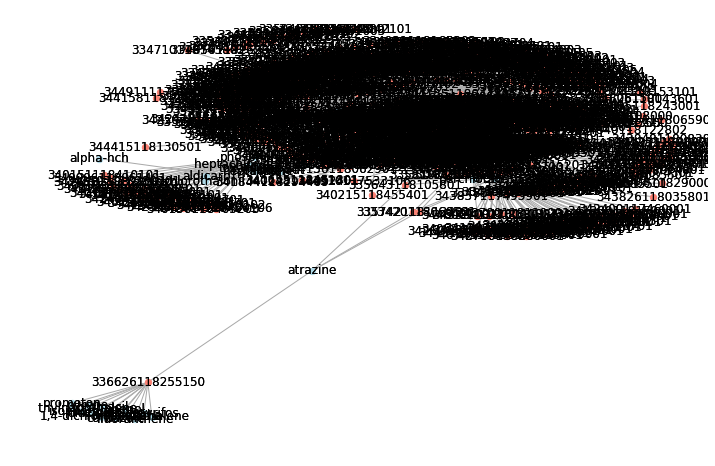

In [620]:
plt.figure(figsize=(12,8))

communities = [sites, pollutants]
colors = ["salmon", "lightblue"]
nx.draw_networkx_edges(pollutant_graph, pos=pos, width = 1, edge_color="darkgray")
for community, color in zip(communities, colors):
    nx.draw_networkx_nodes(pollutant_graph, pos=pos, 
                           nodelist=community,
                           node_color=color,
                           with_labels=False,
                           node_size=40)

    nx.draw_networkx_labels(pollutant_graph,pos=pos)
_=plt.axis("off")

In [624]:
site_graph = bipartite.projected_graph(pollutant_graph, sites)
[len(i) for i in nx.connected_components(site_graph)]

[773]

In [602]:
pos = nx.spring_layout(site_graph, k=0.0001)

/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


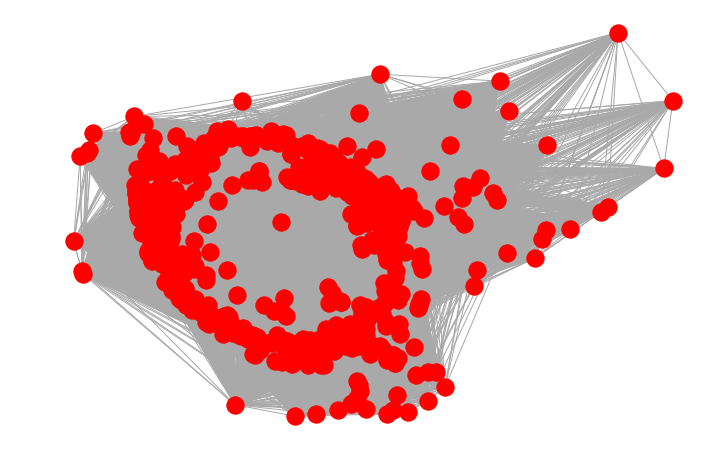

In [603]:
plt.figure(figsize=(12,8))
nx.draw_networkx_edges(site_graph, pos=pos, width = 1, edge_color="darkgray")
nx.draw_networkx_nodes(site_graph, pos=pos, with_labels=False)
_=plt.axis("off")

In [625]:
pollute_graph = bipartite.projected_graph(pollutant_graph, pollutants)
[len(i) for i in nx.connected_components(pollute_graph)]

[51]

## TEST - IT WORKS!!!! 

column = "p01010"
threshold = pollutant_info["Human Health for the consumption of\xa0Water + Organism (µg/L)"][pollutant_info["Pollutant (P = priority pollutant)"]==reverse_params_dict[column]]
actual_threshold = threshold.values[0]
print("Column:", reverse_params_dict[column], "\tThreshold:", actual_threshold)

passed_threshold = total_data[column][total_data[column].notna()] > actual_threshold
has_passed_site = total_data["site_no"][total_data[column].notna()][passed_threshold]
has_passed_nums = total_data[column][total_data[column].notna()][passed_threshold]
#len(passed_threshold)
#len(total_data)

## Let's do this

to_write_to_file = ""
formatSTR = "{}\t{}\t{}\n"
pollutant_col = "Pollutant (P = priority pollutant)"
threshold_col = "Human Health for the consumption of\xa0Water + Organism (µg/L)"

for column in common_pollutants_p:
    threshold = pollutant_info[threshold_col][pollutant_info[pollutant_col]==reverse_params_dict[column]].values[0]
    passed_threshold = total_data[column][total_data[column].notna()] > threshold
    has_passed_site = total_data["site_no"][total_data[column].notna()][passed_threshold]
    has_passed_nums = total_data[column][total_data[column].notna()][passed_threshold]
    
    for i in range(len(has_passed_site)):
        to_add = formatSTR.format(has_passed_site.iloc[i], reverse_params_dict[column], has_passed_nums.iloc[i])
        to_write_to_file += to_add

file = open("potentially_a_bipartite.tsv", "w")
file.write(to_write_to_file)
file.close()

len(common_pollutants_p)

pollutant_info.shape

### Tangent: Looking at the amount of data per parameter 

In [15]:
# Let's see how much data we have for each parameter...
params_counts_dict = {}
for param in a:
    count = a.shape[0] - sum(a[param].isna())
    if count > 0:
        params_counts_dict[params_dict[param]] = count
    
    #print(params_dict[param] + ":", count)
params_counts = list(params_counts_dict.values())

NameError: name 'a' is not defined

In [ ]:
plt.hist(list(params_counts_dict.values()))

In [ ]:
counts_of_counts = {}
for count in params_counts_dict.values():
    if count not in counts_of_counts:
        counts_of_counts[count] = 0
    counts_of_counts[count] += 1

param_counts = list(params_counts_dict.values())
count_counts = list(counts_of_counts.values())
bin_edges = np.logspace(np.log10(min(param_counts)), 
                        np.log10(max(param_counts)),
                        num = 10)
density, _ = np.histogram(param_counts, bins=bin_edges, density=True)

In [ ]:
log_be = np.log10(bin_edges)
x = 10**((log_be[1:] + log_be[:-1])/2)

plt.loglog(x, density, marker='o', linestyle='none')

In [ ]:
log_be